# 1. Running the circuit locally

In [1]:
from qiskit import *

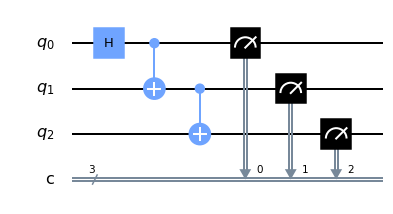

In [3]:
%matplotlib inline
nbits=3
qc=QuantumCircuit(nbits,nbits)
qc.h(0)
qc.cx(0,1)
qc.cx(1,2)
qc.measure(range(nbits),range(nbits))
qc.draw('mpl')

In [5]:
from qiskit.tools.visualization import plot_histogram 

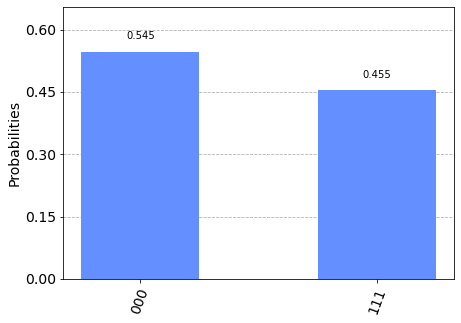

In [6]:
backend=Aer.get_backend('qasm_simulator')
result=execute(qc,backend=backend,shots=1024).result()
plot_histogram(result.get_counts())

# 2. Running the ciucuitr on real device 

In [7]:
IBMQ.load_account()

C:\Users\deathstroke\.conda\envs\13aug_tf-gpu-cuda8\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [8]:
provider=IBMQ.get_provider('ibm-q')
rbackend=provider.get_backend('ibmqx2')

In [10]:
job=execute(qc,backend=rbackend,shots=1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
print(job_monitor(job))

5f48ed879412d600195822f4
Job Status: job has successfully run
None


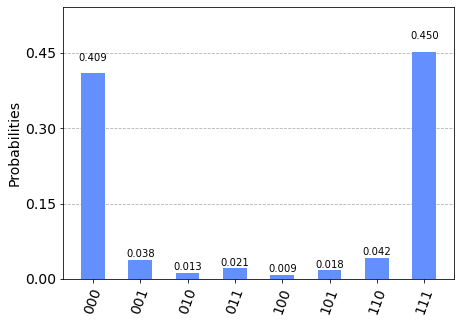

In [11]:
result=job.result()
plot_histogram(result.get_counts())

We notice how the circuit which was supposed to give the same output as above when we ran it on our simulator had some other outputs. This is due to the presence of noise in the real devices. 

# 3. Mitigating Error

In [12]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [13]:
cal_circuits,state_labels = complete_meas_cal(qr=qc.qregs[0],circlabel='measerrormitigationcal')

Here Ignis has given us few calibrational circuits to run, which would tell us what are the errors excatly here.

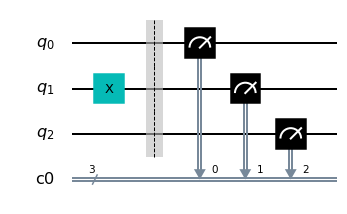

In [21]:
cal_circuits[2].draw('mpl')

In [22]:
len(cal_circuits) # 2^nbits circuits

8

We see above the cal_circuits has 8 calibration circuits against which we are gonna test our qubits to find out the errors

In [26]:
cal_jobs=execute(cal_circuits,
                backend=rbackend,
                shots=1024,
                optimization_level=0)
print(cal_jobs.job_id())
job_monitor(cal_jobs)
cal_results=cal_jobs.result()

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x000001FDA3771288>>
Job Status: job has successfully run


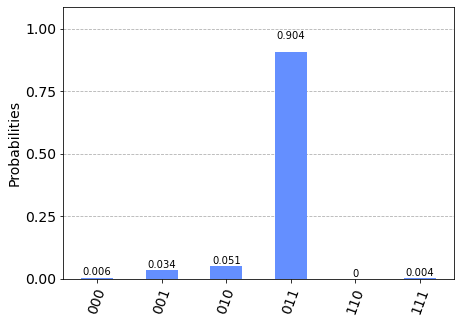

In [27]:
plot_histogram(cal_results.get_counts(cal_circuits[3])) # error for 011 bits state (3 indicates 011 state)

Lets look at the same result in a diffrent representation below (for all the states)

In [28]:
meas_fitter=CompleteMeasFitter(cal_results,state_labels)

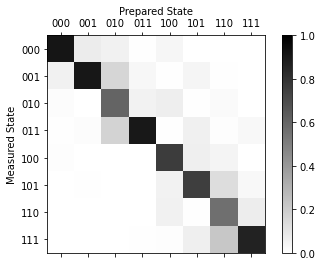

In [29]:
meas_fitter.plot_calibration()

Making a filter from the these calibration measurements to be applied to our intitial result in order to get the mitigated result

In [30]:
meas_filter = meas_fitter.filter

In [36]:
mitigated_result = meas_filter.apply(result)
device_counts = result.get_counts()
mitigated_counts= mitigated_result.get_counts()

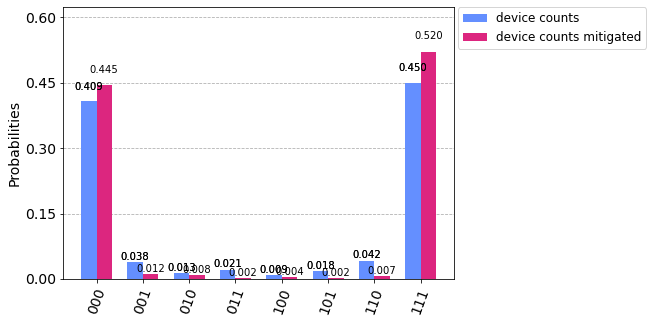

In [37]:
plot_histogram([device_counts,mitigated_counts], legend=["device counts","device counts mitigated"])